### Intel Image Classification
#### Image Scene Classification of Multiclass

Multi-Class-classifier using pretrained Model**(Mobilnetv2)** trained on imagenet dataset and mould it to make a classifier to make predictions on this dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

In [2]:
data_dir = '../input/intel-image-classification'

In [3]:
os.listdir(data_dir)

['seg_test', 'seg_pred', 'seg_train']

In [4]:
test_dir = data_dir + '/seg_test/seg_test'

In [5]:
train_dir = data_dir + '/seg_train/seg_train'

In [6]:
pred_dir = data_dir + '/seg_pred/seg_pred'

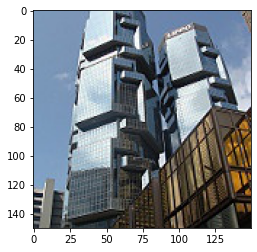

In [7]:
plt.imshow(imread(train_dir+'/buildings/'+os.listdir(train_dir+'/buildings')[0])) # an example of a building

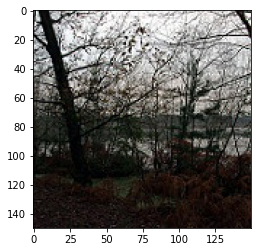

In [8]:
plt.imshow(imread(train_dir+'/forest/'+os.listdir(train_dir+'/forest')[0])) # an example of a forest

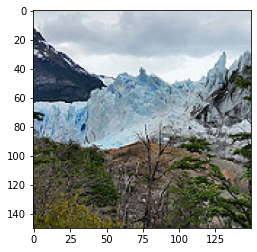

In [9]:
plt.imshow(imread(train_dir+'/glacier/'+os.listdir(train_dir+'/glacier')[0])) # an example of a glacier

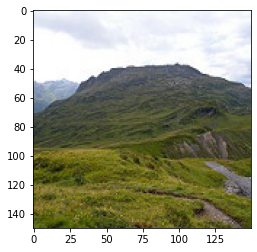

In [10]:
plt.imshow(imread(train_dir+'/mountain/'+os.listdir(train_dir+'/mountain')[0])) # an example of a mountain

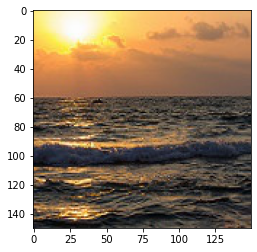

In [11]:
plt.imshow(imread(train_dir+'/sea/'+os.listdir(train_dir+'/sea')[0])) # an example of a sea

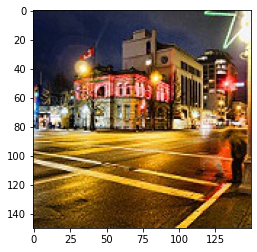

In [12]:
plt.imshow(imread(train_dir+'/street/'+os.listdir(train_dir+'/street')[0])) # an example of street

In [13]:
# this is done so if there are any image of variable shapes so we will reshape all of them to an average shape
dim1 = []
dim2 = []

for image_file in os.listdir(train_dir+'/buildings'):
    img = imread(train_dir+'/buildings/'+image_file)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [14]:
height = int(np.average(d1))
height

150

In [15]:
width = int(np.average(d2))
width

150

In [16]:
img_shape = (height,width,3)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# performing data augmentation and scaling on train set
image_gen_train = ImageDataGenerator(rescale=1/255,
                                    horizontal_flip=True,
                                    zoom_range=0.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.1,
                                    rotation_range=10,
                                    fill_mode='nearest')

In [19]:
# performing scaling on test set
image_gen_test = ImageDataGenerator(rescale=1/255)

In [20]:
# returns an iterator of tuples of (x,y)
# here x is like our x_train and y like y_train
train_data_gen = image_gen_train.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    batch_size=128,
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    target_size=img_shape[:2])

Found 14034 images belonging to 6 classes.


In [21]:
# returns an iterator of tuples of (x,y)
# here x is like our x_train and y like y_train
test_data_gen = image_gen_test.flow_from_directory(directory=test_dir,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  batch_size=128,
                                                  target_size=img_shape[:2],
                                                  shuffle=False)

Found 3000 images belonging to 6 classes.


In [22]:
train_data_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [23]:
test_data_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [24]:
from tensorflow.keras.applications import MobileNetV2

In [59]:
# instantiating a base model which we will not be trained and we'll import this model along with trained weights and biases
# (actually this model was trained on imagenet dataset) we'll not include top of layers of that model because they are less generic
# instead we'll add on more layers later so that this model could make predictions on this dataset.
base_model = MobileNetV2(include_top=False,
                        weights='imagenet',
                        input_shape=img_shape)

In [60]:
base_model.trainable = False # freezing the base model layers to avoid it's retraining.

In [61]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [62]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [63]:
global_layer = GlobalAveragePooling2D() # this layer provides us a vetor of features from the just previous volume of base model.

In [64]:
pred_layer = Dense(6) # this layer makes raw predictions i.e, it returns numbers as logits.

In [65]:
model = Sequential([base_model,global_layer,pred_layer]) # our modified model.

In [96]:
model.summary() # see we have some trainable parameters these are due to the layers which we added on later.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [66]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [67]:
model.compile(optimizer=Adam(),
             loss=CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
early_stop = EarlyStopping(monitor='val_loss',patience=2) # to avoid overfitting.

In [70]:
history = model.fit(train_data_gen,
         validation_data=test_data_gen,
         epochs=15,
         callbacks=[early_stop])

Epoch 1/15
110/110 [==============================] - 111s 1s/step - loss: 0.6664 - accuracy: 0.7555 - val_loss: 0.3710 - val_accuracy: 0.8630
Epoch 2/15
110/110 [==============================] - 112s 1s/step - loss: 0.4341 - accuracy: 0.8397 - val_loss: 0.3339 - val_accuracy: 0.8740
Epoch 3/15
110/110 [==============================] - 116s 1s/step - loss: 0.4191 - accuracy: 0.8467 - val_loss: 0.3080 - val_accuracy: 0.8860
Epoch 4/15
110/110 [==============================] - 113s 1s/step - loss: 0.4054 - accuracy: 0.8487 - val_loss: 0.3098 - val_accuracy: 0.8863
Epoch 5/15
110/110 [==============================] - 112s 1s/step - loss: 0.3838 - accuracy: 0.8566 - val_loss: 0.2827 - val_accuracy: 0.8953
Epoch 6/15
110/110 [==============================] - 109s 990ms/step - loss: 0.3758 - accuracy: 0.8617 - val_loss: 0.2851 - val_accuracy: 0.8970
Epoch 7/15
110/110 [==============================] - 110s 1s/step - loss: 0.3679 - accuracy: 0.8664 - val_loss: 0.2789 - val_accuracy: 0.8

In [71]:
# trend of losses
loss_metrics = pd.DataFrame(model.history.history)
loss_metrics

,loss,accuracy,val_loss,val_accuracy
0,0.666409,0.755451,0.371019,0.863000
1,0.434095,0.839675,0.333913,0.874000
2,0.419065,0.846729,0.307999,0.886000
3,0.405397,0.848725,0.309782,0.886333
4,0.383833,0.856563,0.282736,0.895333
5,0.375802,0.861693,0.285102,0.897000
6,0.367936,0.866396,0.278924,0.895333
7,0.367684,0.864828,0.279160,0.895333
8,0.362059,0.867108,0.293386,0.888667


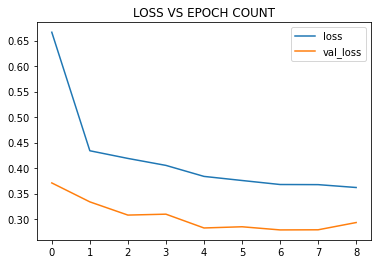

In [72]:
loss_metrics[['loss','val_loss']].plot(title='LOSS VS EPOCH COUNT')

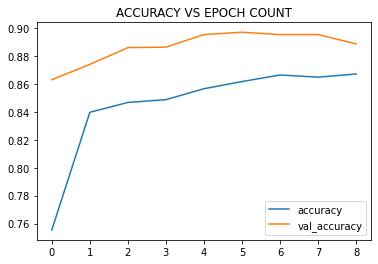

In [73]:
loss_metrics[['accuracy','val_accuracy']].plot(title='ACCURACY VS EPOCH COUNT')

In [97]:
test_data_gen.classes

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [99]:
predictions = model.predict_classes(test_data_gen)
predictions

array([0, 0, 0, ..., 5, 5, 5])

In [100]:
from sklearn.metrics import classification_report,confusion_matrix

In [101]:
print(classification_report(test_data_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       437
           1       0.98      0.99      0.99       474
           2       0.87      0.76      0.81       553
           3       0.76      0.90      0.82       525
           4       0.96      0.88      0.92       510
           5       0.92      0.91      0.91       501

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



In [102]:
print(confusion_matrix(test_data_gen.classes,predictions))

[[402   1   0   3   0  31]
 [  0 470   1   2   0   1]
 [  1   5 419 113  11   4]
 [  3   3  39 472   7   1]
 [  6   0  23  29 449   3]
 [ 45   0   1   1   0 454]]


from above classification report it is clear that our model performs pretty well on all classes except class 2 and class 3 which corresponds to glacier and mountain respectively. It's great reason which i found could be because many mountains have glaciers surrounding them so our model got confused between whether to say it a mountain or a glacier as in many pictures it is difficult to say whether it's a glacier or a mountain especially when the concentration of ice forming glacier is very less near a mountain.
but still i'll try to make a new classifier soon with improved accuracy till then let's make predictions on some image from prediction dataset provided.

In [103]:
def predict_label(class_number):
    if class_number==0:
        return 'building'
    elif class_number==1:
        return 'forest'
    elif class_number==2:
        return 'glacier'
    elif class_number==3:
        return 'mountain'
    elif class_number==4:
        return 'sea'
    else:
        return 'street'

In [104]:
from tensorflow.keras.preprocessing import image

In [137]:
def predict_name(directory_to_img):
    pred_image = image.load_img(directory_to_img,target_size=img_shape)
    pred_image_array = image.img_to_array(pred_image)
    pred_image_array = pred_image_array/255
    pred_image_array = pred_image_array.reshape(1,150,150,3)
    prediction = model.predict_classes(pred_image_array)[0]
    plt.imshow(imread(directory_to_img))
    return predict_label(prediction)

'forest'

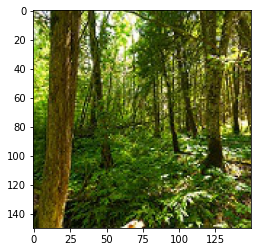

In [140]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[0])

'glacier'

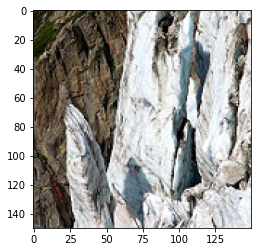

In [141]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[1])

'mountain'

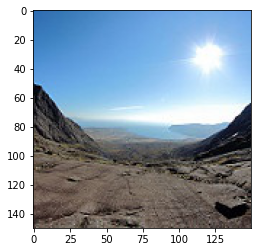

In [160]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[9])

'mountain'

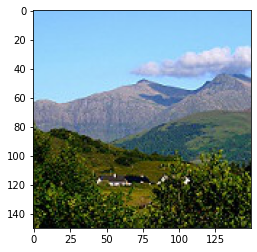

In [143]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[3])

'forest'

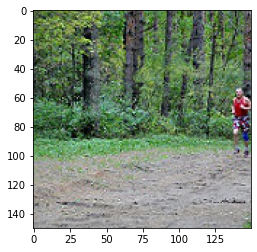

In [144]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[4])

'glacier'

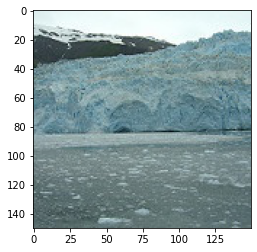

In [146]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[10])

'building'

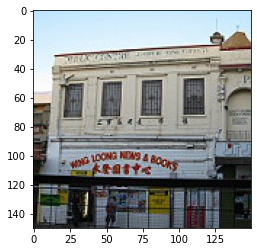

In [150]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[67])

'street'

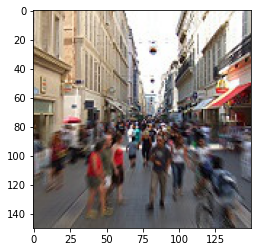

In [152]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[33])

'forest'

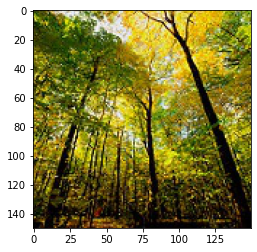

In [156]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[37])

'sea'

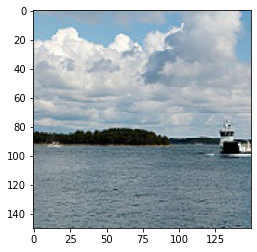

In [161]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[72])

#### data source : https://www.kaggle.com/puneet6060/intel-image-classification